Deep Lab V3 Pretrained Model

In [1]:
!pip install scikit-image

In [2]:

import torch
import os
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from torch.utils.data import Dataset, DataLoader
import torchvision
import zipfile
import datetime

#### Checks if Files Loaded

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# checks if the data is available

if not os.path.exists('./parsed'):
    zip_file_name = './drive/MyDrive/parsed.zip'

    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        # Extract all the contents of zip file in current directory
        zip_ref.extractall()

    print("Data is Loaded")
else:
    print("Data is Already Loaded")


Data is Loaded


Data Loader

In [5]:

img_dataset = "./parsed/images"
mask_dataset = "./parsed/masks"


WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GREY = (127, 127, 127)

# Create train validation and test sets
class ImageDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.image_list = os.listdir(image_paths)
        self.mask_list = os.listdir(mask_paths)
        self.image_list.sort()
        self.mask_list.sort()
        self.mask_value = {
            WHITE: 0,
            BLACK: 1,
            GREY: 2
        }

    def __getitem__(self, index):

        img = io.imread(self.image_paths + "/" + self.image_list[index])
        mask = io.imread(self.mask_paths + "/" + self.mask_list[index])

        ## Convert Grey Scale to One Hot Encoding
        new_mask = np.zeros((mask.shape[0], mask.shape[1], 3))

        for idx in range(0,3):
            new_mask[:, :, idx] = np.isin(mask[:, :, 0], list(self.mask_value.keys())[idx]).astype(int)

        img = img.transpose(1,0,2)
        new_mask = new_mask.transpose(1,0,2)

        if self.transform is not None:
            img = self.transform(img)
            new_mask = self.transform(new_mask)

        return img, new_mask

    def __len__(self):
        return len(self.image_list)

#### Loss

In [6]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, output, target):
        output = torch.sigmoid(output)
        intersection = (output * target).sum()
        union = output.sum() + target.sum()
        dice = 2.0 * intersection / (union + self.eps)
        return 1.0 - dice

def class_iou(output, target, num_classes=3):
    ious = []
    smooth = 1e-6
    output = torch.sigmoid(output)
    output = output.argmax(dim=1)
    target = target.argmax(dim=1)
    for cls in range(num_classes):

        intersection = ((output == cls) & (target == cls)).sum().float()
        union = ((output == cls) | (target == cls)).sum().float()

        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            ious.append((intersection + smooth) / (union + smooth))

    # we want to focus on the flesh + tools (less so on the background)
    total = 0.4 * ious[0] + 0.2 * ious[1] + 0.4 * ious[2]
    total = total/3
    return total

#### Load Data

Dataset Size: 8080
Train Dataset: 5656
Validation Dataset: 1616
Test Dataset: 808


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


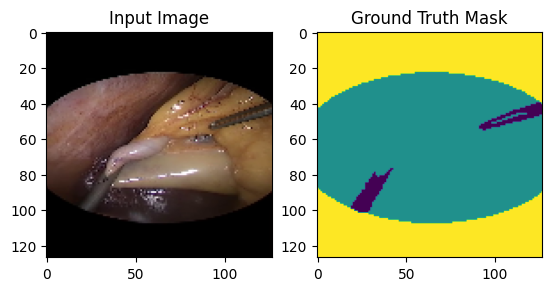

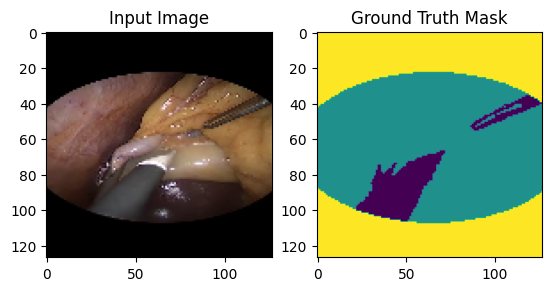

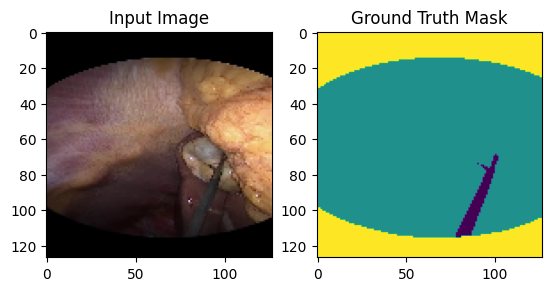

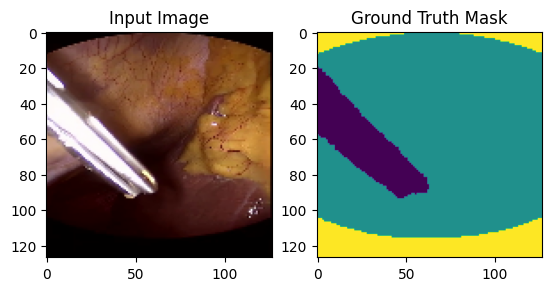

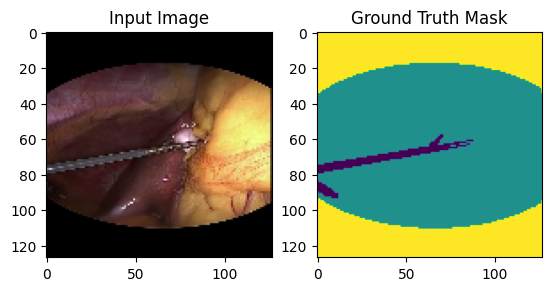

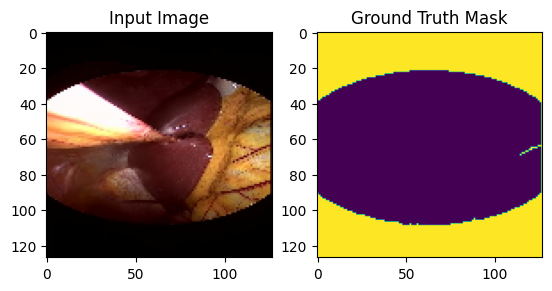

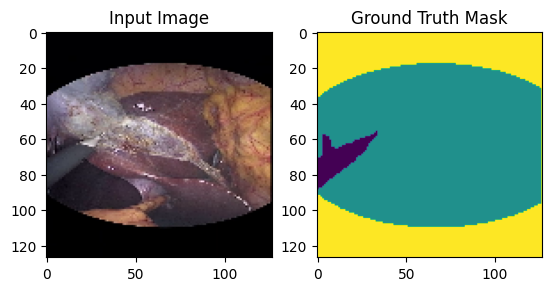

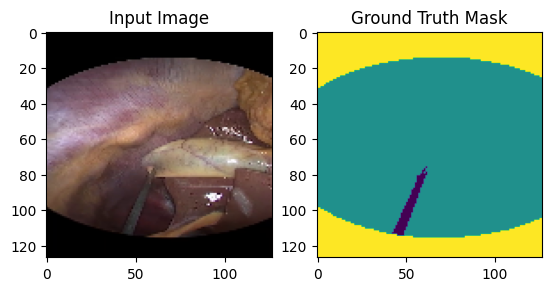

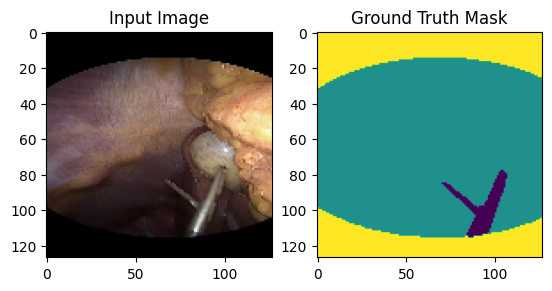

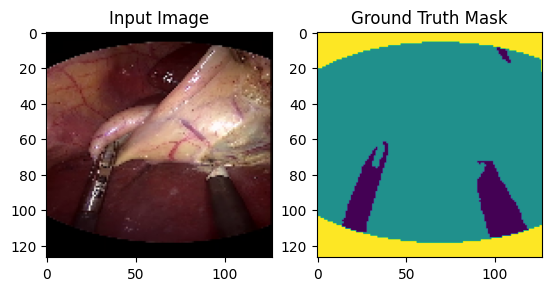

In [7]:

from torchvision.transforms import Grayscale


# Split the dataset into train, validation and test sets
train_split = 0.7
val_split = 0.2
test_split = 0.1

# batch size
batch_size = 100

# num workers
num_workers = 0

# transforms
transform = transforms.Compose([
    transforms.ToTensor(),

    # resize to 127 x 127
    transforms.Resize((127, 127))

])

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the dataset
dataset = ImageDataset(img_dataset, mask_dataset, transform=transform)

print("Dataset Size: {}".format(len(dataset)))

# split the dataset into train, validation and test sets
train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# if GPU pin memory
pin_memory = True if device == 'cuda' else False

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# check the dataset
print("Train Dataset: {}".format(len(train_dataset)))
print("Validation Dataset: {}".format(len(val_dataset)))
print("Test Dataset: {}".format(len(test_dataset)))

# sanity check images via visualization
def visualize(data_loader):
    for batch_idx, (data, target) in enumerate(data_loader):

        data, target = data.to(device), target.to(device)

        for i in range(10):
            plt.subplot(1, 2, 1)
            plt.imshow(data[i].cpu().permute(1, 2, 0))
            plt.title("Input Image")
            plt.subplot(1, 2, 2)
            plt.imshow(target[i].cpu().argmax(dim=0))
            plt.title("Ground Truth Mask")
            plt.show()

        break

def visualizeImage(num:int ):
    img_pat = "./parsed/images/img_"+ str(num) + ".png"
    mask_pat = "./parsed/masks/img_"+ str(num) + ".png"
    img = io.imread(img_pat)
    mask = io.imread(mask_pat)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title("Ground Truth Mask")
    plt.show()



visualize(test_loader)
plt.show()



#### Model

In [8]:
def getModel():
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=False)

    # # set output layer to just 3
    # model.classifier[-1] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))

    model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)

    # set output layer to just 3
    model.classifier[4] = torch.nn.Conv2d(512, 3, kernel_size=(1, 1), stride=(1, 1))

    return model


#### Utility Functions for Train and Test

In [9]:
def train(model,criterion,optimizer,accFunction,dataset,device,listLoss,listAcc):

    model.train()

    totalLoss = 0
    totalAcc = 0
    for batch_idx, (data, target) in enumerate(dataset):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)['out']

        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        currLoss = loss.item()
        currAcc = accFunction(output,target)

        totalLoss += currLoss
        totalAcc += currAcc

        listLoss.append(currLoss)
        listAcc.append(currAcc)

        if batch_idx % 10 == 0:
            print("Batch: {} Loss: {} Acc: {}".format(batch_idx, loss.item(),currAcc))


    totalAcc /= len(dataset)
    totalLoss /= len(dataset)

    print("Loss: {} Accuracy: {}".format(totalLoss,totalAcc))

    return totalLoss,totalAcc.item()

def test(model,criterion,accFunction,dataset,device,listLoss,listAcc):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():

        acc = 0
        loss = 0
        for batch_idx, (data,target) in enumerate(dataset):
            data,target = data.to(device),target.to(device)

            output = model(data)['out']

            pred = output.argmax(dim=1,keepdim=True)

            currAcc = accFunction(output,target)
            currLoss = criterion(output,target)

            listLoss.append(currLoss)
            listAcc.append(currAcc)

            acc += currAcc
            loss += loss


    acc /= len(dataset)
    loss /= len(dataset)

    print("Loss: {} Accuracy: {}".format(loss,acc))

    return loss,acc.item()

#### Release Cache Function

In [10]:
pip install pynvml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.3 MB/s eta 0:00:00


In [11]:
import gc
import pynvml
def report_gpu():
   print(torch.cuda.list_gpu_processes())
   gc.collect()
   torch.cuda.empty_cache()

In [12]:
report_gpu()

GPU:0
process      34708 uses      958.000 MB GPU memory


In [31]:
def saveModel(model, name):
  torch.save(model.state_dict(), f"/content/drive/MyDrive/{name}")

def loadModel(model, name):
  model.load_state_dict(torch.load(f"/content/drive/MyDrive/{name}"))
  return model

#### Full Loop

In [33]:
num_epochs = 5

# learning rate
lr = 0.001

# # criterion
# criterion = DiceLoss()

# criterion
criterion = torch.nn.CrossEntropyLoss()

# # optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# # device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)



def trainLoop(model,scheduler,optimizer,accFunction,times):
    # Hyper parameters
    # train the model
    trainLossList = []
    trainAccList = []
    validLossList = []
    validAccList = []
    torch.cuda.empty_cache()
    model = model.to(device)
    best_valid_acc = 0.0

    for epoch in range(num_epochs):
        report_gpu()

        print("Epoch " + str(epoch)+ " ---------------------------------------------")
        currTime = datetime.datetime.now()

        trainLoss, trainAcc = train(model, criterion, optimizer,accFunction, train_loader, device,trainLossList,trainAccList)
        validLoss, validAcc = test(model, criterion,accFunction, val_loader, device,validLossList,validAccList)
        scheduler.step()
        endTime = datetime.datetime.now() - currTime
        endTime = endTime.total_seconds() * 1000

        times.append(endTime)

        # Save the model if validation accuracy (iou score) improved
        if validAcc > best_valid_acc:
          best_valid_acc = validAcc
          print("Saving new best model from epoch " + str(epoch) + " with IoU accuracy " + str(best_valid_acc))
          saveModel(model, "best_model.pth")
          torch.cuda.empty_cache()

        print("-----------------------------------------------------------------")
    return trainLossList,trainAccList,validLossList,validAccList


#### Plot

In [34]:
def plot(validLossList,validAccList,trainLossList,trainAccList, times):
        # convert to tensor
    validLossList = torch.tensor(validLossList)
    validAccList = torch.tensor(validAccList)
    trainLossList = torch.tensor(trainLossList)
    trainAccList = torch.tensor(trainAccList)

    # move to cpu
    validLossList = validLossList.cpu()
    validAccList = validAccList.cpu()
    trainLossList = trainLossList.cpu()
    trainAccList = validAccList.cpu()

    # convert back to list
    validLossList = validLossList.tolist()
    validAccList = validAccList.tolist()

    # plot the loss and accuracy in 2 by 2 grid

    plt.subplot(2, 2, 1)
    plt.plot(trainLossList)
    plt.title("Training Loss")
    plt.xlabel("Batch")

    plt.subplot(2, 2, 2)
    plt.plot(trainAccList)
    plt.title("Training Accuracy")
    plt.xlabel("Batch")

    plt.subplot(2, 2, 3)
    plt.plot(validLossList)
    plt.title("Validation Loss")
    plt.xlabel("Batch")

    plt.subplot(2, 2, 4)
    plt.plot(validAccList)
    plt.title("Validation Accuracy")
    plt.xlabel("Batch")

    plt.tight_layout()
    plt.show()

    # plot times
    plt.plot(times)
    plt.title("Time")
    plt.xlabel("Batch")
    plt.ylabel("Time")
    plt.show()



#### Loop for Time Analysis

ROUND: 0
GPU:0
process      34708 uses     4428.000 MB GPU memory
Epoch 0 ---------------------------------------------
Batch: 0 Loss: 1.1136070698643938 Acc: 0.0487569123506546
Batch: 10 Loss: 0.17683939036234084 Acc: 0.24115906655788422
Batch: 20 Loss: 0.10997811073906043 Acc: 0.2641035318374634
Batch: 30 Loss: 0.09989873978529884 Acc: 0.27429020404815674
Batch: 40 Loss: 0.08582054747358801 Acc: 0.27500253915786743
Batch: 50 Loss: 0.0912790292728954 Acc: 0.28102681040763855
Loss: 0.16163403425144704 Accuracy: 0.2510022819042206
Loss: 0.0 Accuracy: 0.27581310272216797
Saving new best model from epoch 0 with IoU accuracy 0.27581310272216797
-----------------------------------------------------------------
GPU:0
process      34708 uses     2876.000 MB GPU memory
Epoch 1 ---------------------------------------------
Batch: 0 Loss: 0.06999429097777145 Acc: 0.28394636511802673
Batch: 10 Loss: 0.07333860740021547 Acc: 0.2819383144378662
Batch: 20 Loss: 0.10846537286875006 Acc: 0.27653348445

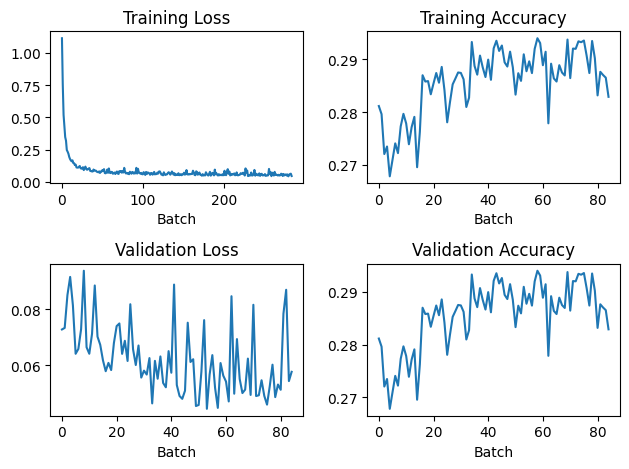

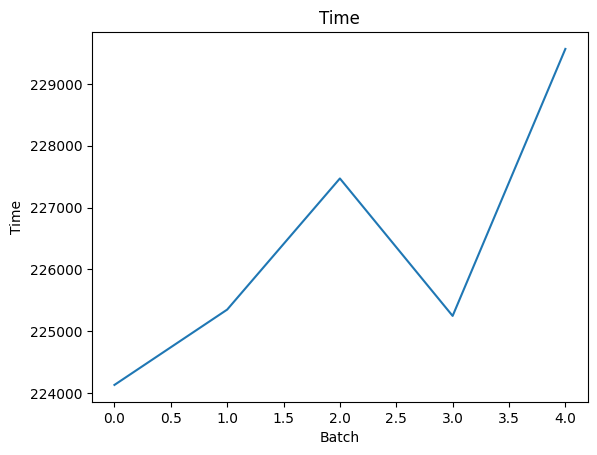

Total Time For Round: 0 is 229563.853ms
ROUND: 1
GPU:0
process      34708 uses     2560.000 MB GPU memory
Epoch 0 ---------------------------------------------
Batch: 0 Loss: 1.1708926486972078 Acc: 0.03392881900072098
Batch: 10 Loss: 0.23994271364385433 Acc: 0.20753167569637299
Batch: 20 Loss: 0.13241221049621932 Acc: 0.25205665826797485
Batch: 30 Loss: 0.10159322756294158 Acc: 0.260611891746521
Batch: 40 Loss: 0.08857373593111023 Acc: 0.27783286571502686
Batch: 50 Loss: 0.0763294852945507 Acc: 0.27873486280441284
Loss: 0.18870955487996458 Accuracy: 0.2429197132587433
Loss: 0.0 Accuracy: 0.2764319181442261
Saving new best model from epoch 0 with IoU accuracy 0.2764319181442261
-----------------------------------------------------------------
GPU:0
process      34708 uses     2814.000 MB GPU memory
Epoch 1 ---------------------------------------------
Batch: 0 Loss: 0.09272774943070812 Acc: 0.27741262316703796
Batch: 10 Loss: 0.07956790063684734 Acc: 0.27502939105033875
Batch: 20 Loss:

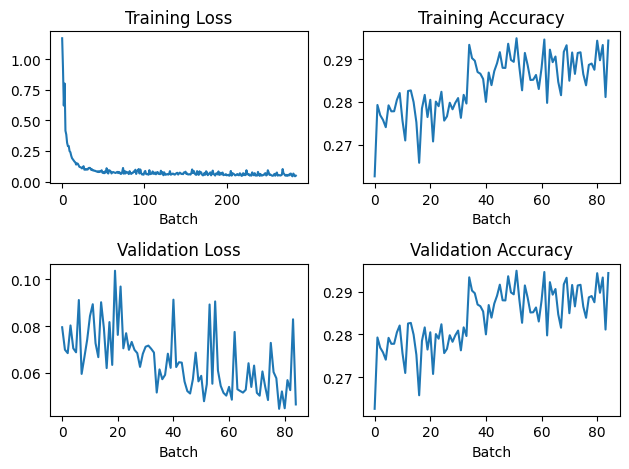

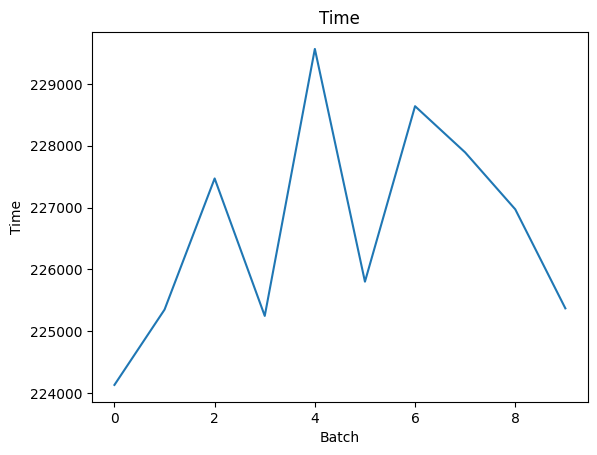

Total Time For Round: 1 is 225369.82499999998ms
ROUND: 2
GPU:0
process      34708 uses     2676.000 MB GPU memory
Epoch 0 ---------------------------------------------
Batch: 0 Loss: 1.153812614216501 Acc: 0.03328895568847656
Batch: 10 Loss: 0.22636051961847264 Acc: 0.19922873377799988
Batch: 20 Loss: 0.14118101502553235 Acc: 0.2466583102941513
Batch: 30 Loss: 0.10292650919004583 Acc: 0.2614579498767853
Batch: 40 Loss: 0.10247592919227401 Acc: 0.26793938875198364
Batch: 50 Loss: 0.07786932362900617 Acc: 0.2785509526729584
Loss: 0.19248401772245974 Accuracy: 0.23763731122016907
Loss: 0.0 Accuracy: 0.2729663550853729
Saving new best model from epoch 0 with IoU accuracy 0.2729663550853729
-----------------------------------------------------------------
GPU:0
process      34708 uses     3204.000 MB GPU memory
Epoch 1 ---------------------------------------------
Batch: 0 Loss: 0.07074316685634523 Acc: 0.27977749705314636
Batch: 10 Loss: 0.07311507827289372 Acc: 0.2830149829387665
Batch: 2

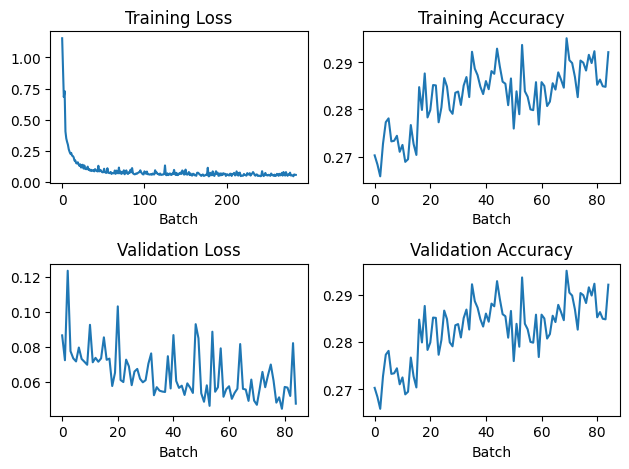

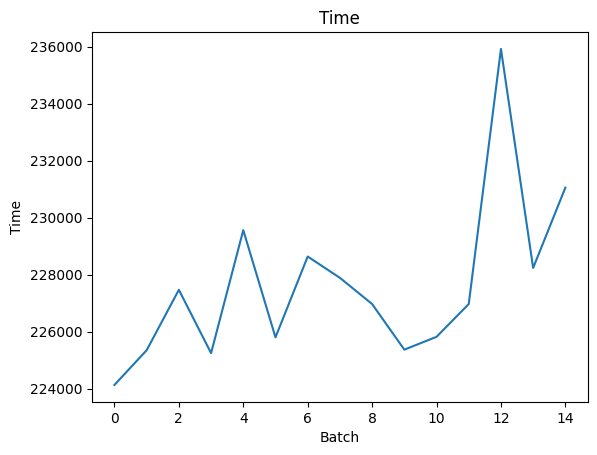

Total Time For Round: 2 is 231054.804ms
ROUND: 3
GPU:0
process      34708 uses     2964.000 MB GPU memory
Epoch 0 ---------------------------------------------
Batch: 0 Loss: 1.112185168846515 Acc: 0.04069450870156288
Batch: 10 Loss: 0.21693055800254218 Acc: 0.20438170433044434
Batch: 20 Loss: 0.12690483293079818 Acc: 0.2523432970046997
Batch: 30 Loss: 0.10958742436632751 Acc: 0.2588055729866028
Batch: 40 Loss: 0.10930316488455438 Acc: 0.26970285177230835
Batch: 50 Loss: 0.07530490502107223 Acc: 0.27596163749694824
Loss: 0.178696862987619 Accuracy: 0.24314160645008087
Loss: 0.0 Accuracy: 0.2782895565032959
Saving new best model from epoch 0 with IoU accuracy 0.2782895565032959
-----------------------------------------------------------------
GPU:0
process      34708 uses     2998.000 MB GPU memory
Epoch 1 ---------------------------------------------
Batch: 0 Loss: 0.08189499690637525 Acc: 0.28192138671875
Batch: 10 Loss: 0.06976207515619043 Acc: 0.2852279543876648
Batch: 20 Loss: 0.08

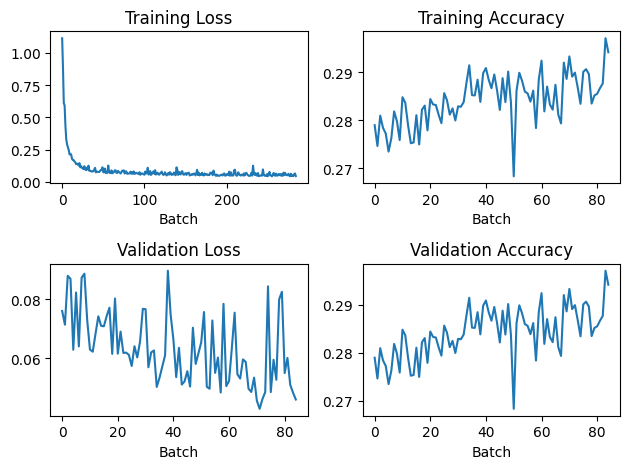

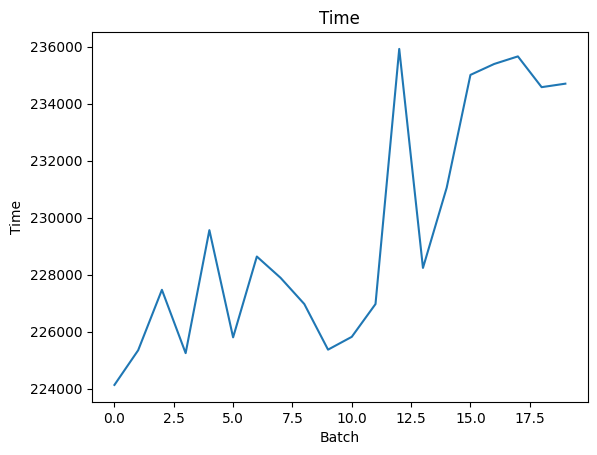

Total Time For Round: 3 is 234704.59399999998ms
ROUND: 4
GPU:0
process      34708 uses     2742.000 MB GPU memory
Epoch 0 ---------------------------------------------
Batch: 0 Loss: 1.1013922465115364 Acc: 0.04926089569926262
Batch: 10 Loss: 0.22290801596044088 Acc: 0.1869746297597885
Batch: 20 Loss: 0.13698462547822343 Acc: 0.24086956679821014
Batch: 30 Loss: 0.10654867112682385 Acc: 0.25721898674964905
Batch: 40 Loss: 0.09089407250847514 Acc: 0.26885467767715454
Batch: 50 Loss: 0.08444249398179773 Acc: 0.27805185317993164
Loss: 0.1922689765654103 Accuracy: 0.23475320637226105
Loss: 0.0 Accuracy: 0.272239089012146
Saving new best model from epoch 0 with IoU accuracy 0.272239089012146
-----------------------------------------------------------------
GPU:0
process      34708 uses     2868.000 MB GPU memory
Epoch 1 ---------------------------------------------
Batch: 0 Loss: 0.0785722439979924 Acc: 0.28202024102211
Batch: 10 Loss: 0.07771225433648571 Acc: 0.2786564230918884
Batch: 20 Lo

In [ ]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
numTimes = 5 # set this to 1 if you want to run it once

totalTimes = []

for i in range(numTimes):
    print("ROUND: " + str(i))

    model = getModel() # Beware of ordering of lines, need to create new instance

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    trainLossList,trainAccList,validLossList,validAccList= trainLoop(model,scheduler,optimizer,class_iou,totalTimes)

    plot(validLossList,validAccList,trainLossList,trainAccList,totalTimes)

    print("Total Time For Round: " + str(i) + " is " + str(totalTimes[-1]) + "ms")

#### Stats

In [ ]:

print(totalTimes)

# Average Time
print("Average Time (ms): {}".format(sum(totalTimes)/len(totalTimes)))

# Standard Deviation
print("Standard Deviation: {}".format(np.std(totalTimes)))

#### Test Output

In [ ]:
testLossList = []
testAccList = []


currTime = datetime.datetime.now()
test(model, criterion,class_iou, test_loader, device,testLossList,testAccList)
endTime  = datetime.datetime.now() - currTime


testLossList = torch.tensor(testLossList)
testAccList = torch.tensor(testAccList)

# move to cpu
testLossList = testLossList.cpu()
testAccList = testAccList.cpu()

# convert to numpy
testLossList = np.array(testLossList)
testAccList = np.array(testAccList)

# Averages
print("Test Loss: {} Test Accuracy: {}".format(sum(testLossList)/len(testLossList),sum(testAccList)/len(testAccList)))

# Inference Time
endTime = endTime.total_seconds() * 1000
print("Inference Time: {}ms".format(endTime))

# Standard Deviation
print("Standard Deviation: {}".format(np.std(testLossList)))
print("Standard Deviation: {}".format(np.std(testAccList)))

#### Visualize Examples

In [ ]:
# visualize examples 10

def visualize(data_loader):
    for batch_idx, (data, target) in enumerate(data_loader):

        data, target = data.to(device), target.to(device)

        for i in range(10):
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(data[i].cpu().permute(1, 2, 0))
            plt.title("Input Image")
            plt.subplot(1, 3, 2)
            plt.imshow(target[i].cpu().argmax(dim=0))
            plt.title("Ground Truth Mask")

            plt.show()

        break

# visualize(test_loader)


model.eval()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)

        output = model(data)['out']
        pred = output.argmax(dim=1, keepdim=True)

        for i in range(10):
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(data[i].cpu().permute(1, 2, 0))
            plt.title("Input Image")
            plt.subplot(1, 3, 2)
            plt.imshow(target[i].cpu().argmax(dim=0))
            plt.title("Ground Truth Mask")
            plt.subplot(1, 3, 3)
            plt.imshow(pred[i].cpu().squeeze())
            plt.title("Predicted Mask")
            plt.show()

        break
